In [27]:
import os
import json
import pandas as pd
import pandas_profiling
import numpy as np
from scipy import stats
import statsmodels.api as sm
from patsy import dmatrices
from matplotlib import pyplot as plt
import rpy2
import statsmodels.api as smapi
from statsmodels.formula.api import ols
import statsmodels.graphics as smgraphics

In [28]:
%matplotlib inline

# Statistical analysis of feature computations results


## Data importation and manipulation

In [29]:
def get_path_to_all_files(folder_name):
    """Recursively get all filepaths from a directory tree."""

    filepaths = []
    for dirname, dirnames, filenames in os.walk(folder_name):
        for filename in filenames:
            if '.DS_Store' not in filename:
                filepaths.append(os.path.join(dirname, filename))

    return filepaths

### Data importation


In [30]:
results_folder = "/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data"

In [31]:
files = get_path_to_all_files(results_folder)

#### Force plate feature data

In [32]:
fp_files = [file for file in files if "FP" in file]
fp_files[1:5]

['/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/1_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/2_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/3_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/4_3_cop_features.json']

#### Wii Balance Board feature data


In [33]:
wbb_files = [file for file in files if "FP" not in file]
wbb_files[1:5]

['/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/1_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/2_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/3_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/4_3_cop_features.json']

In [34]:
wbb_files_modified = [filename.replace("BB","FP") for filename in wbb_files]
fp_files_modified = [filename.replace("FP","BB") for filename in fp_files]

In [35]:
fp_files_curated = [file for file in fp_files if file in wbb_files_modified]
wbb_files_curated = [file for file in wbb_files if file in fp_files_modified]

In [36]:
print(fp_files_curated[1])
print(wbb_files_curated[1])
len(fp_files_curated)

/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/1_3_cop_features.json
/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/1_3_cop_features.json


72

In [37]:
identical_order_test = [i for i, j in zip(fp_files_curated, wbb_files_curated) if i == j.replace("BB","FP")]

In [38]:
if len(identical_order_test) == len(fp_files_curated):
    print("hello")

hello


###  Data manipulation

In [39]:
def create_index(df):
    arrays = [df["device"].values, df["subject"].values, 
             df["trial"].values, df["balance board"].values]
    tuples = list(zip(*arrays))
    return pd.MultiIndex.from_tuples(tuples, names=['device', 'subject','trial','balance board'])
    

In [40]:
def create_and_merge_dataframes(files):
    time_frames = []
    frequency_frames = []
    for filepath in files:
        with open(filepath) as json_data:
            features = json.load(json_data)     
            time_features = features["time_features"]
            frequency_features = features["frequency_features"]
            
            for dic in (time_features,frequency_features):
                dic["device"] = features["device"]
                dic["subject"] = features["subject"]
                dic["trial"] = features["trial"]
                dic["balance board"] = features["balance board"]

        time_frames.append(pd.DataFrame(time_features, index=[0]))
        frequency_frames.append(pd.DataFrame(frequency_features,index=[0]))
    
    time_features_df = pd.concat(time_frames, axis=0)    
    frequency_features_df = pd.concat(frequency_frames, axis=0)

    df1 = time_features_df.reset_index().drop(['device', 'subject','trial','balance board'], 1)
    df1.index = create_index(time_features_df)
    df1.drop('index', 1, inplace=True)
    df1.sort_index(inplace=True)
    
    df2 = frequency_features_df.reset_index().drop(['device', 'subject','trial','balance board'], 1)
    df2.index = create_index(frequency_features_df)
    df2.drop('index', 1, inplace=True)
    df2.sort_index(inplace=True)
    
    return (df1,df2)

####  WBB  features results merging

In [41]:
wbb_time, wbb_freq = create_and_merge_dataframes(wbb_files)

In [42]:
wbb_time.head()

Mean distance  Mean distance-ML  \
device subject trial balance board                                    
BB     1       1     1                   1.178873          0.833589   
                     2                   0.782512          0.553319   
                     3                   0.946229          0.669085   
                     4                   0.758238          0.536155   
               2     1                   0.645156          0.456194   

                                    Mean distance-AP  Rms distance  \
device subject trial balance board                                   
BB     1       1     1                      2.724147      1.446494   
                     2                      0.894254      0.881046   
                     3                      1.584823      1.188297   
                     4                      1.481299      0.899871   
               2     1                      2.785792      0.801096   

                                    Rms distance-ML  Rms distance-AP  \
device subject trial balance board                                     
BB     1       1     1                     1.022826         3.390515   
                     2                     0.622994         1.155406   
                     3                     0.840253         2.068492   
                     4                     0.636305         1.791744   
               2     1                     0.566461         3.205057   

                                       Range  Range-ML   Range-AP  \
device subject trial balance board                                  
BB     1       1     1              2.984499  4.191090  14.770991   
                     2              1.895966  2.618424   5.588320   
                     3              3.024378  4.168320  11.522189   
                     4              2.201346  3.050034   7.184143   
               2     1              2.061404  2.828736  11.764030   

                                    Mean velocity  Mean velocity-ML  \
device subject trial balance board                                    
BB     1       1     1                   3.274705          1.621632   
                     2                   2.145970          0.787972   
                     3                   3.103128          0.817815   
                     4                   3.003512          1.314265   
               2     1                   2.855064          1.327117   

                                    Mean velocity-AP  \
device subject trial balance board                     
BB     1       1     1                      2.412547   
                     2                      1.756316   
                     3                      2.804372   
                     4                      2.417822   
               2     1                      2.187732   

                                    95% confidence circle area  \
device subject trial balance board                               
BB     1       1     1                               20.552347   
                     2                                6.591717   
                     3                               14.235491   
                     4                                7.600504   
               2     1                                6.391629   

                                    95% confidence elipse area  Sway area  \
device subject trial balance board                                          
BB     1       1     1                              130.860014   2.029810   
                     2                               17.163615   0.708371   
                     3                               52.079657   1.248743   
                     4                               34.748678   1.231784   
               2     1                              100.911934   2.017643   

                                    Mean frequency  Mean frequency-ML  \
device subject trial balance board                                      
BB     1       1  

In [43]:
wbb_freq.head()

Total power-RD  Total power-ML  \
device subject trial balance board                                   
BB     1       1     1                    0.479142        4.603257   
                     2                    0.131171        0.753559   
                     3                    0.279910        2.648245   
                     4                    0.173195        2.259300   
               2     1                    0.190271        3.658337   

                                    Total power-AP  Peak frequency-RD  \
device subject trial balance board                                      
BB     1       1     1                    0.507113               0.20   
                     2                    0.156673               0.25   
                     3                    0.296769               0.20   
                     4                    0.238365               0.25   
               2     1                    0.206809               0.15   

                                    Peak frequency-ML  Peak frequency-AP  \
device subject trial balance board                                         
BB     1       1     1                           0.15               0.15   
                     2                           0.15               0.15   
                     3                           0.15               0.15   
                     4                           0.20               0.15   
               2     1                           0.15               0.15   

                                    50% power frequency-RD  \
device subject trial balance board                           
BB     1       1     1                                0.45   
                     2                                0.55   
                     3                                0.30   
                     4                                0.55   
               2     1                                0.60   

                                    50% power frequency-ML  \
device subject trial balance board                           
BB     1       1     1                                0.20   
                     2                                0.25   
                     3                                0.30   
                     4                                0.35   
               2     1                                0.20   

                                    50% power frequency-AP  \
device subject trial balance board                           
BB     1       1     1                                0.25   
                     2                                0.20   
                     3                                0.20   
                     4                                0.45   
               2     1                                0.50   

                                    80% power frequency-RD  \
device subject trial balance board                           
BB     1       1     1                                0.75   
                     2                                0.80   
                     3                                0.50   
                     4                                1.05   
               2     1                                0.95   

                                    80% power frequency-ML  \
device subject trial balance board                           
BB     1       1     1                                0.30   
                     2                                0.50   
                     3                                0.45   
                     4                                0.50   
               2     1                                0.30   

                                    80% power frequency-AP  \
device subject trial balance board                           
BB     1       1     1                                0.65   
                     2                                0.60   
                     3                                0.40   
               

#### FP  features results merging

In [44]:
fp_time,fp_freq = create_and_merge_dataframes(fp_files)

In [45]:
fp_time.head()

Mean distance  Mean distance-ML  \
device subject trial balance board                                    
FP     1       1     1                   2.019561          1.428045   
                     2                   1.294167          0.915114   
                     3                   1.781858          1.259964   
                     4                   1.470629          1.039892   
               2     1                   1.280834          0.905686   

                                    Mean distance-AP  Rms distance  \
device subject trial balance board                                   
FP     1       1     1                      4.307447      2.539511   
                     2                      1.563916      1.498875   
                     3                      2.494333      2.239190   
                     4                      2.362092      1.768889   
               2     1                      4.334872      1.584353   

                                    Rms distance-ML  Rms distance-AP  \
device subject trial balance board                                     
FP     1       1     1                     1.795705         5.539376   
                     2                     1.059865         1.988427   
                     3                     1.583347         3.112560   
                     4                     1.250793         2.895039   
               2     1                     1.120306         4.988016   

                                       Range  Range-ML   Range-AP  \
device subject trial balance board                                  
FP     1       1     1              6.209965  8.450483  27.450084   
                     2              3.281951  4.470678  10.208092   
                     3              5.686031  6.958073  15.747676   
                     4              4.816017  6.620390  12.482777   
               2     1              4.589324  5.903164  19.345924   

                                    Mean velocity  Mean velocity-ML  \
device subject trial balance board                                    
FP     1       1     1                   9.332174          5.410759   
                     2                   6.896215          2.931900   
                     3                   8.862089          3.694307   
                     4                   9.400786          5.290737   
               2     1                   8.460316          5.040417   

                                    Mean velocity-AP  \
device subject trial balance board                     
FP     1       1     1                      6.417907   
                     2                      5.609295   
                     3                      7.307340   
                     4                      6.644126   
               2     1                      5.829478   

                                    95% confidence circle area  \
device subject trial balance board                               
FP     1       1     1                               65.103642   
                     2                               20.236877   
                     3                               50.582926   
                     4                               29.949754   
               2     1                               24.892357   

                                    95% confidence elipse area  Sway area  \
device subject trial balance board                                          
FP     1       1     1                              365.385159  11.663783   
                     2                               58.366882   3.944298   
                     3                              139.772752   6.941336   
                     4                              108.335924   8.260827   
               2     1                              263.525512  11.712612   

                                    Mean frequency  Mean frequency-ML  \
device subject trial balance board                                      
FP     1       1  

In [46]:
fp_freq.head()

Total power-RD  Total power-ML  \
device subject trial balance board                                   
FP     1       1     1                    1.852500       13.132269   
                     2                    0.487169        2.755562   
                     3                    1.243365        6.467280   
                     4                    0.850897        6.194172   
               2     1                    0.801546        9.698939   

                                    Total power-AP  Peak frequency-RD  \
device subject trial balance board                                      
FP     1       1     1                    1.928987               0.15   
                     2                    0.505599               0.85   
                     3                    1.286857               0.20   
                     4                    1.111900               1.00   
               2     1                    0.964897               0.65   

                                    Peak frequency-ML  Peak frequency-AP  \
device subject trial balance board                                         
FP     1       1     1                           0.15               0.15   
                     2                           0.15               0.15   
                     3                           0.15               0.15   
                     4                           0.20               0.15   
               2     1                           0.15               0.15   

                                    50% power frequency-RD  \
device subject trial balance board                           
FP     1       1     1                                0.65   
                     2                                0.70   
                     3                                0.45   
                     4                                1.00   
               2     1                                0.85   

                                    50% power frequency-ML  \
device subject trial balance board                           
FP     1       1     1                                0.20   
                     2                                0.40   
                     3                                0.30   
                     4                                0.35   
               2     1                                0.20   

                                    50% power frequency-AP  \
device subject trial balance board                           
FP     1       1     1                                0.50   
                     2                                0.35   
                     3                                0.30   
                     4                                0.65   
               2     1                                0.70   

                                    80% power frequency-RD  \
device subject trial balance board                           
FP     1       1     1                                1.20   
                     2                                1.00   
                     3                                0.90   
                     4                                1.70   
               2     1                                1.75   

                                    80% power frequency-ML  \
device subject trial balance board                           
FP     1       1     1                                0.30   
                     2                                0.80   
                     3                                0.55   
                     4                                0.60   
               2     1                                0.35   

                                    80% power frequency-AP  \
device subject trial balance board                           
FP     1       1     1                                0.90   
                     2                                0.85   
                     3                                0.70   
               

##### OUTLIER DETECTION !!!
 

In [47]:
fp_outlier_values = fp_time[fp_time["Mean distance"]==fp_time["Mean distance"].max()]
fp_outlier_values

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,Mean velocity-ML,Mean velocity-AP,95% confidence circle area,95% confidence elipse area,Sway area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,
FP,5,1,4,3.865687,2.733454,3.178744,4.419742,3.12523,3.894948,8.669005,11.435533,19.010014,11.505051,4.234483,9.831919,171.578556,278.380056,14.119281,0.473677,0.273851,0.546774,1.565361,1.491057


In [48]:
fp_outlier_index = fp_outlier_values.index.tolist()
fp_outlier_index

[('FP', '5', '1', '4')]

In [49]:
wbb_outlier_values = wbb_time[wbb_time["Mean distance"]==wbb_time["Mean distance"].max()]
wbb_outlier_values

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,Mean velocity-ML,Mean velocity-AP,95% confidence circle area,95% confidence elipse area,Sway area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,
BB,5,1,4,2.563564,1.812713,2.053394,2.947088,2.083906,2.481717,5.461938,7.247493,9.673379,2.868869,1.300682,2.238556,77.133352,113.86852,2.30029,0.178109,0.126843,0.192717,1.300455,1.25852


In [50]:
wbb_outlier_index = wbb_outlier_values.index.tolist()
wbb_outlier_index

[('BB', '5', '1', '4')]

In [51]:
fp_outlier_values = fp_time.loc[(fp_time.index.get_level_values('subject') == wbb_outlier_index[0][1])
                                           & (fp_time.index.get_level_values('trial') == wbb_outlier_index[0][2]) 
                                           & (fp_time.index.get_level_values('balance board') == wbb_outlier_index[0][3])
                                          ]

fp_outlier_values

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,Mean velocity-ML,Mean velocity-AP,95% confidence circle area,95% confidence elipse area,Sway area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,
FP,5,1,4,3.865687,2.733454,3.178744,4.419742,3.12523,3.894948,8.669005,11.435533,19.010014,11.505051,4.234483,9.831919,171.578556,278.380056,14.119281,0.473677,0.273851,0.546774,1.565361,1.491057


## Statistical analysis

### General descriptive statistics HTML reports 

In [52]:
wbb_time.head()
wbb_time.index.get_level_values(3)
wbb_time_1 = wbb_time.loc[(wbb_time.index.get_level_values(3)=="1")]

In [53]:
outputfile = "/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/notebooks/results/wbb_data_1_time_domain_report.html"
df_profile = pandas_profiling.ProfileReport(wbb_time_1, bins=50)
df_profile.to_file(outputfile=outputfile)

### Features mean value and standard deviation 

In [54]:
def compute_mean_and_stds(df1, df2):
    """Compute the mean and standard deviation values for each feature and each balance board."""

    wbb_and_fp_results = pd.concat([df1, df2], axis=0) 
    feature_mean_results= wbb_and_fp_results.groupby([wbb_and_fp_results.index.get_level_values(0),wbb_and_fp_results.index.get_level_values(3)]).mean().transpose().stack(0).unstack()
    feature_std_results= wbb_and_fp_results.groupby([wbb_and_fp_results.index.get_level_values(0),wbb_and_fp_results.index.get_level_values(3)]).std().transpose().stack(0).unstack()
    aggregated_results = (feature_mean_results, feature_std_results)
    
    return aggregated_results

In [55]:
time_mean_results, time_std_results = compute_mean_and_stds(wbb_time, fp_time)

In [56]:
time_mean_results.head()

balance board            1                   2                   3            \
device                  BB        FP        BB        FP        BB        FP   
Mean distance     0.941062  1.678796  0.989717  1.975601  0.935505  1.635103   
Mean distance-ML  0.665431  1.187088  0.699835  1.396961  0.661502  1.156193   
Mean distance-AP  2.341533  3.659998  2.171975  3.547060  1.913712  2.980023   
Rms distance      1.164977  2.178994  1.337736  2.673327  1.189199  2.071075   
Rms distance-ML   0.823763  1.540781  0.945922  1.890328  0.840890  1.464471   

balance board            4            
device                  BB        FP  
Mean distance     1.085677  1.869869  
Mean distance-ML  0.767690  1.322197  
Mean distance-AP  2.153621  3.443939  
Rms distance      1.324929  2.304107  
Rms distance-ML   0.936866  1.629250

### Spearman correlation

In [57]:
def compute_spearman_correlation(df1, df2):
    
    wbb_numbers = ["1", "2", "3", "4"]
    dfs_1 = [df1.loc[(df1.index.get_level_values(3) == number)] for number in wbb_numbers]
    dfs_2 = [df2.loc[(df2.index.get_level_values(3) == number)] for number in wbb_numbers]
    
    result_dict = {key:{} for key in df1.columns}
    
    for (df1, df2, number) in zip(dfs_1, dfs_2, wbb_numbers):
        # Loop over each feature
        for column in df1.columns:
            x = df1[column]
            y = df2[column]

            # Compute the spearman coefficient(rho) and the corresponding p-value
            rho, p_value = stats.spearmanr(x, y, nan_policy="propagate")

            # Store the results
            result_dict[column][number] = {}
            result_dict[column][number]["p-value"] = p_value
            result_dict[column][number]["rho"] = rho
            
    result_dict_collapsed = {(outer_k, inner_k): inner_v for outer_k in result_dict
               for inner_k, inner_v in result_dict[outer_k].items()}

    aggregated_results = pd.DataFrame.from_dict(result_dict_collapsed).transpose()
    aggregated_results = aggregated_results.unstack().stack(0).unstack()

    return aggregated_results

In [58]:
time_spearman_results = compute_spearman_correlation(wbb_time, fp_time)

In [59]:
time_spearman_results.head()

1                       2            \
                                 p-value       rho       p-value       rho   
95% confidence circle area  9.114947e-06  0.847265  4.351447e-06  0.861570   
95% confidence elipse area  1.559765e-09  0.950464  5.465151e-07  0.894628   
Fractal dimension-CC        9.432615e-03  0.593395  1.306418e-02  0.572314   
Fractal dimension-CE        4.974862e-05  0.808050  1.526863e-03  0.690083   
Mean distance               1.384760e-04  0.779154  3.937551e-05  0.814050   

                                       3                       4            
                                 p-value       rho       p-value       rho  
95% confidence circle area  6.827381e-05  0.799587  5.422111e-07  0.894737  
95% confidence elipse area  1.227968e-07  0.913223  6.859458e-09  0.940144  
Fractal dimension-CC        8.461116e-07  0.888430  2.791462e-03  0.661507  
Fractal dimension-CE        8.997005e-04  0.712810  6.775962e-05  0.799794  
Mean distance               7.722365e-04  0.719008  1.648270e-06  0.878225

In [60]:
wbb_time.columns

Index(['Mean distance', 'Mean distance-ML', 'Mean distance-AP', 'Rms distance',
       'Rms distance-ML', 'Rms distance-AP', 'Range', 'Range-ML', 'Range-AP',
       'Mean velocity', 'Mean velocity-ML', 'Mean velocity-AP',
       '95% confidence circle area', '95% confidence elipse area', 'Sway area',
       'Mean frequency', 'Mean frequency-ML', 'Mean frequency-AP',
       'Fractal dimension-CC', 'Fractal dimension-CE'],
      dtype='object')

### Pearson's correlation coefficient and regression lines equations 


In [61]:
fp_time_cut = fp_time[:wbb_time.shape[0]]

In [62]:
def plot_correlation(df1,df2,name="time_domain"):
    columns = df1.columns
    fig, axs = plt.subplots(8,3,figsize=(15,25),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    #axs[-1, -1].axis('off')
    for ax, column in zip(axs.ravel(), columns):
        x = df1[column]
        y = df2[column]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        ax.plot(x, y, '.', label='original data')
        ax.plot(x, intercept + slope*x, 'black', label='fitted line', linewidth=0.3)
        ax.set_xlabel('Balance Board')
        ax.set_ylabel('Force plate')
        ax.set_title(column, weight = 600)
        r_squared = round(r_value**2,4)
        ax.text(0.8, 0.4, "p-value = {}".format(round(p_value,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.3, "R\u00b2={}".format(r_squared), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.2, "Slope = {}".format(round(slope,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.1, "Intercept = {}".format(round(intercept,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        #ax.legend()
    plt.savefig("results/{}_correlation_plots.png".format(name), bbox_inches='tight')


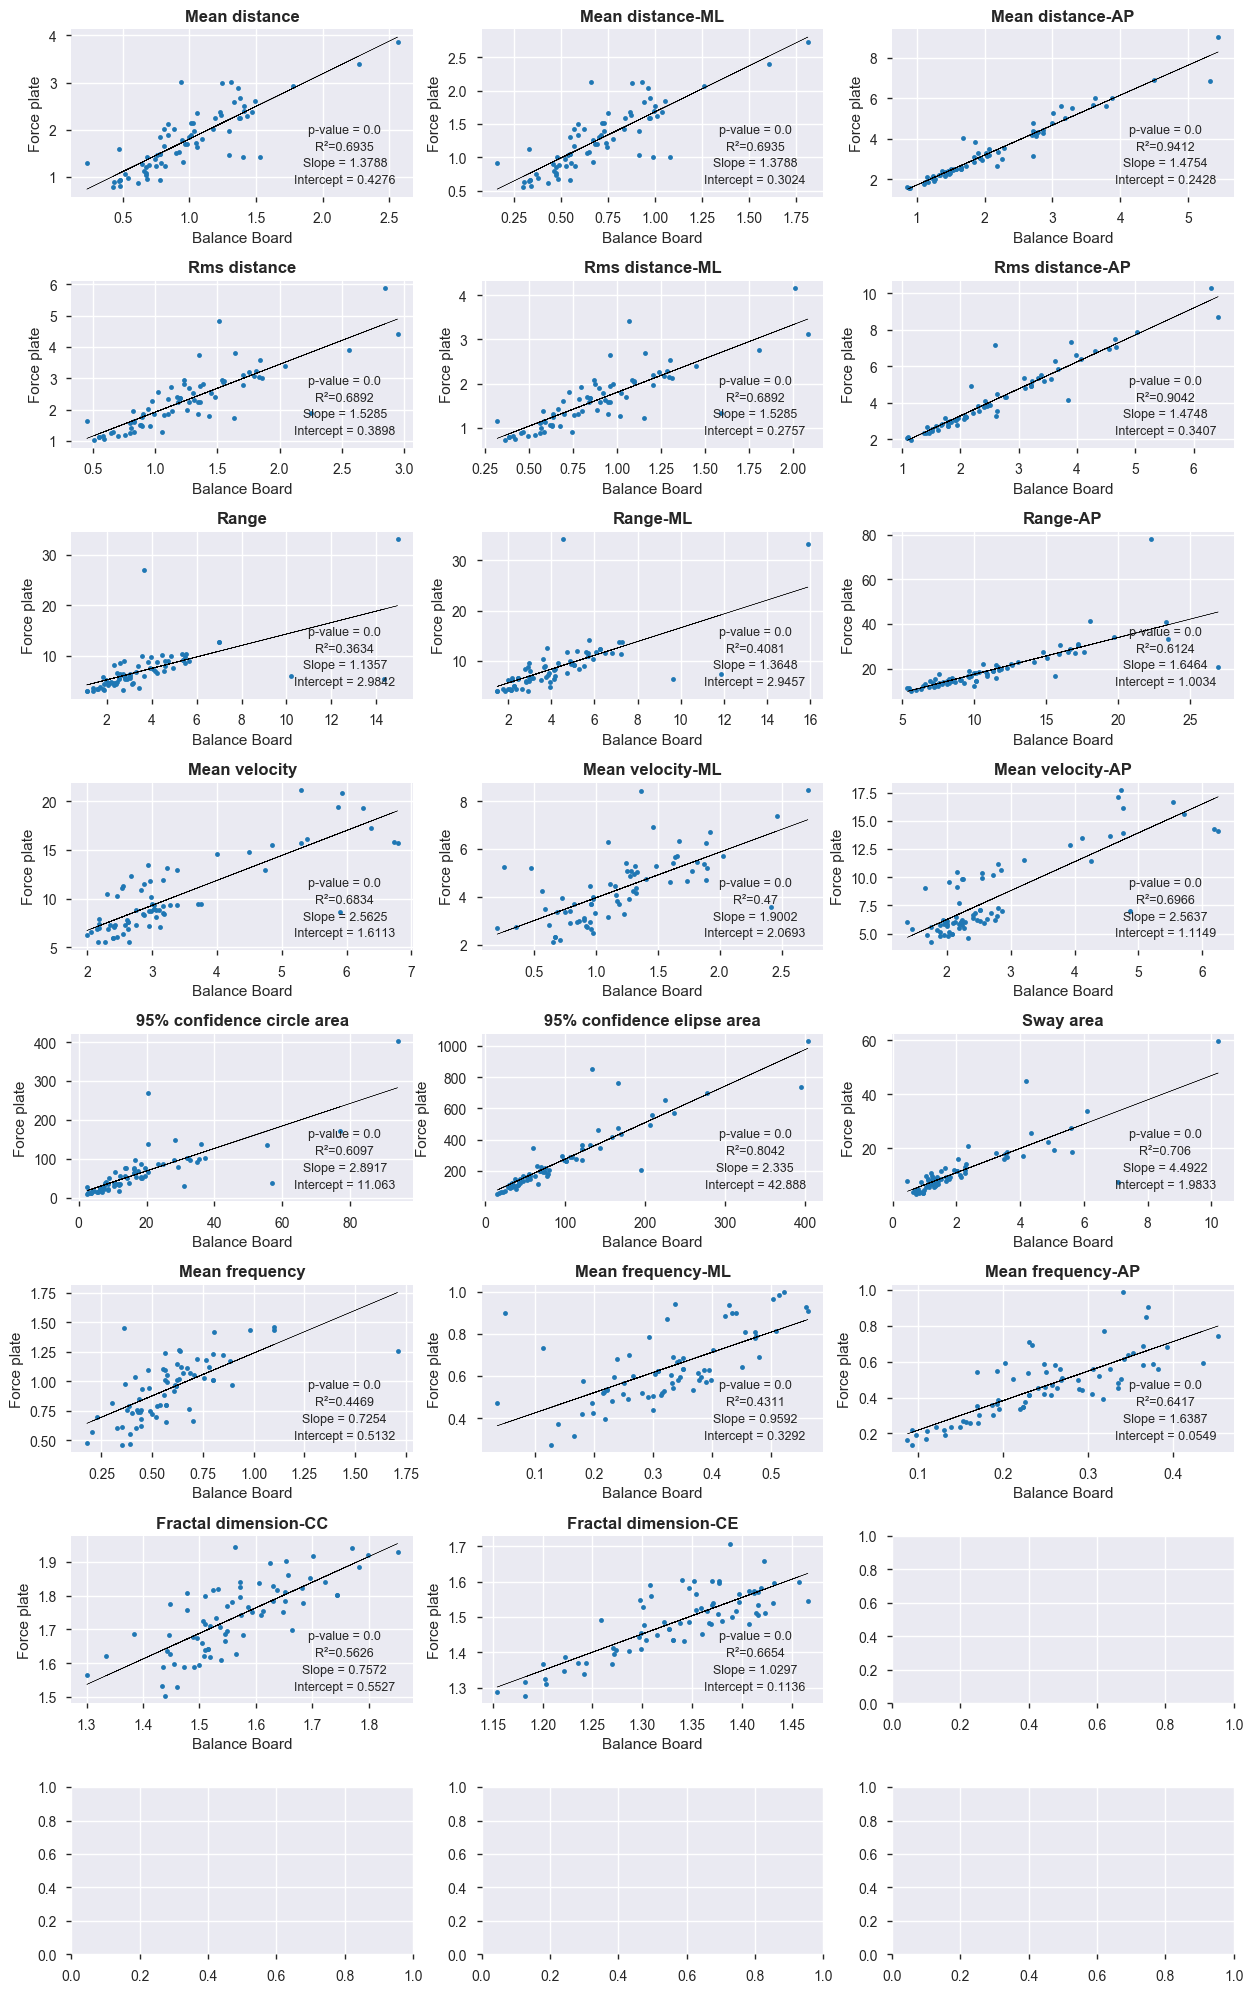

In [63]:
plot_correlation(wbb_time, fp_time_cut)

In [64]:
def plot_correlation_2(df1,df2):
    columns = df1.columns
    fig, axs = plt.subplots(6,3,figsize=(20,30),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    axs[-1, -1].axis('off')
    for ax, column in zip(axs.ravel(), columns):
        x = df1[column]
        y = df2[column]
        regression = ols("data ~ x", data=dict(data=y, x=x)).fit(covtype="scale")
        
        # Find outliers #
        test = regression.outlier_test()
        outliers = ((x[i],y[i]) for i,t in enumerate(test["unadj_p"]) if t < 0.5)
        #print ('Outliers: ', list(outliers))
        
        smgraphics.regressionplots.plot_fit(regression, 1, ax=ax)
        # Add line
        smgraphics.regressionplots.abline_plot(model_results=regression, ax=ax)
        
        #ax.plot(x, y, '.', label='original data')
        ax.set_xlabel('Balance Board')
        ax.set_ylabel('Force plate')
        ax.set_title(column, weight = 600)

        #ax.legend()
    #plt.savefig("results/{}_correlation_plots.png".format(name), bbox_inches='tight')



In [65]:
#plot_correlation_2(wbb_time, fp_time_cut)

### Bland and Altman plots + LOA (limit of agreement)

In [66]:
def bland_altman_plot(df1, df2, name="time_domain"):
    columns = df1.columns
    fig, axs = plt.subplots(8,3,figsize=(20,30),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    df1= df1.reorder_levels(['balance board','device','subject','trial']).sort_index()
    df2= df2.reorder_levels(['balance board','device','subject','trial']).sort_index()

    for ax, column in zip(axs.ravel(), columns):
        x = df1[column].values
        y = df2[column].values
        data1 = np.asarray(x)
        data2 = np.asarray(y)
        #mean = np.mean([x, y], axis=0)
        trials = [trial for trial in range(len(data1))]
        diff = x - y 
        md = np.mean(diff)               
        sd = np.std(diff, axis=0)

        ax.scatter(trials, diff, marker='.',s=60, color = "gray",  )
        trials_limits = [x * 18 + 0.5 for x in range(1, 4)]
        for limit in trials_limits:
            ax.axvline(limit,color='black', linestyle='--', linewidth=0.5)

        ax.axhline(md,color='tomato', linestyle='--')
        ax.axhline(md + 2*sd, color='teal', linestyle='--', linewidth=0.5)
        ax.axhline(md - 2*sd, color='teal', linestyle='--', linewidth=0.5)
        ax.set_xlabel('Trials')
        ax.set_ylabel('Difference')
        ax.set_title(column, weight = 600)
        
        #ax.legend()
    plt.savefig("results/{}_bland_altman_plots.png".format(name), bbox_inches='tight')

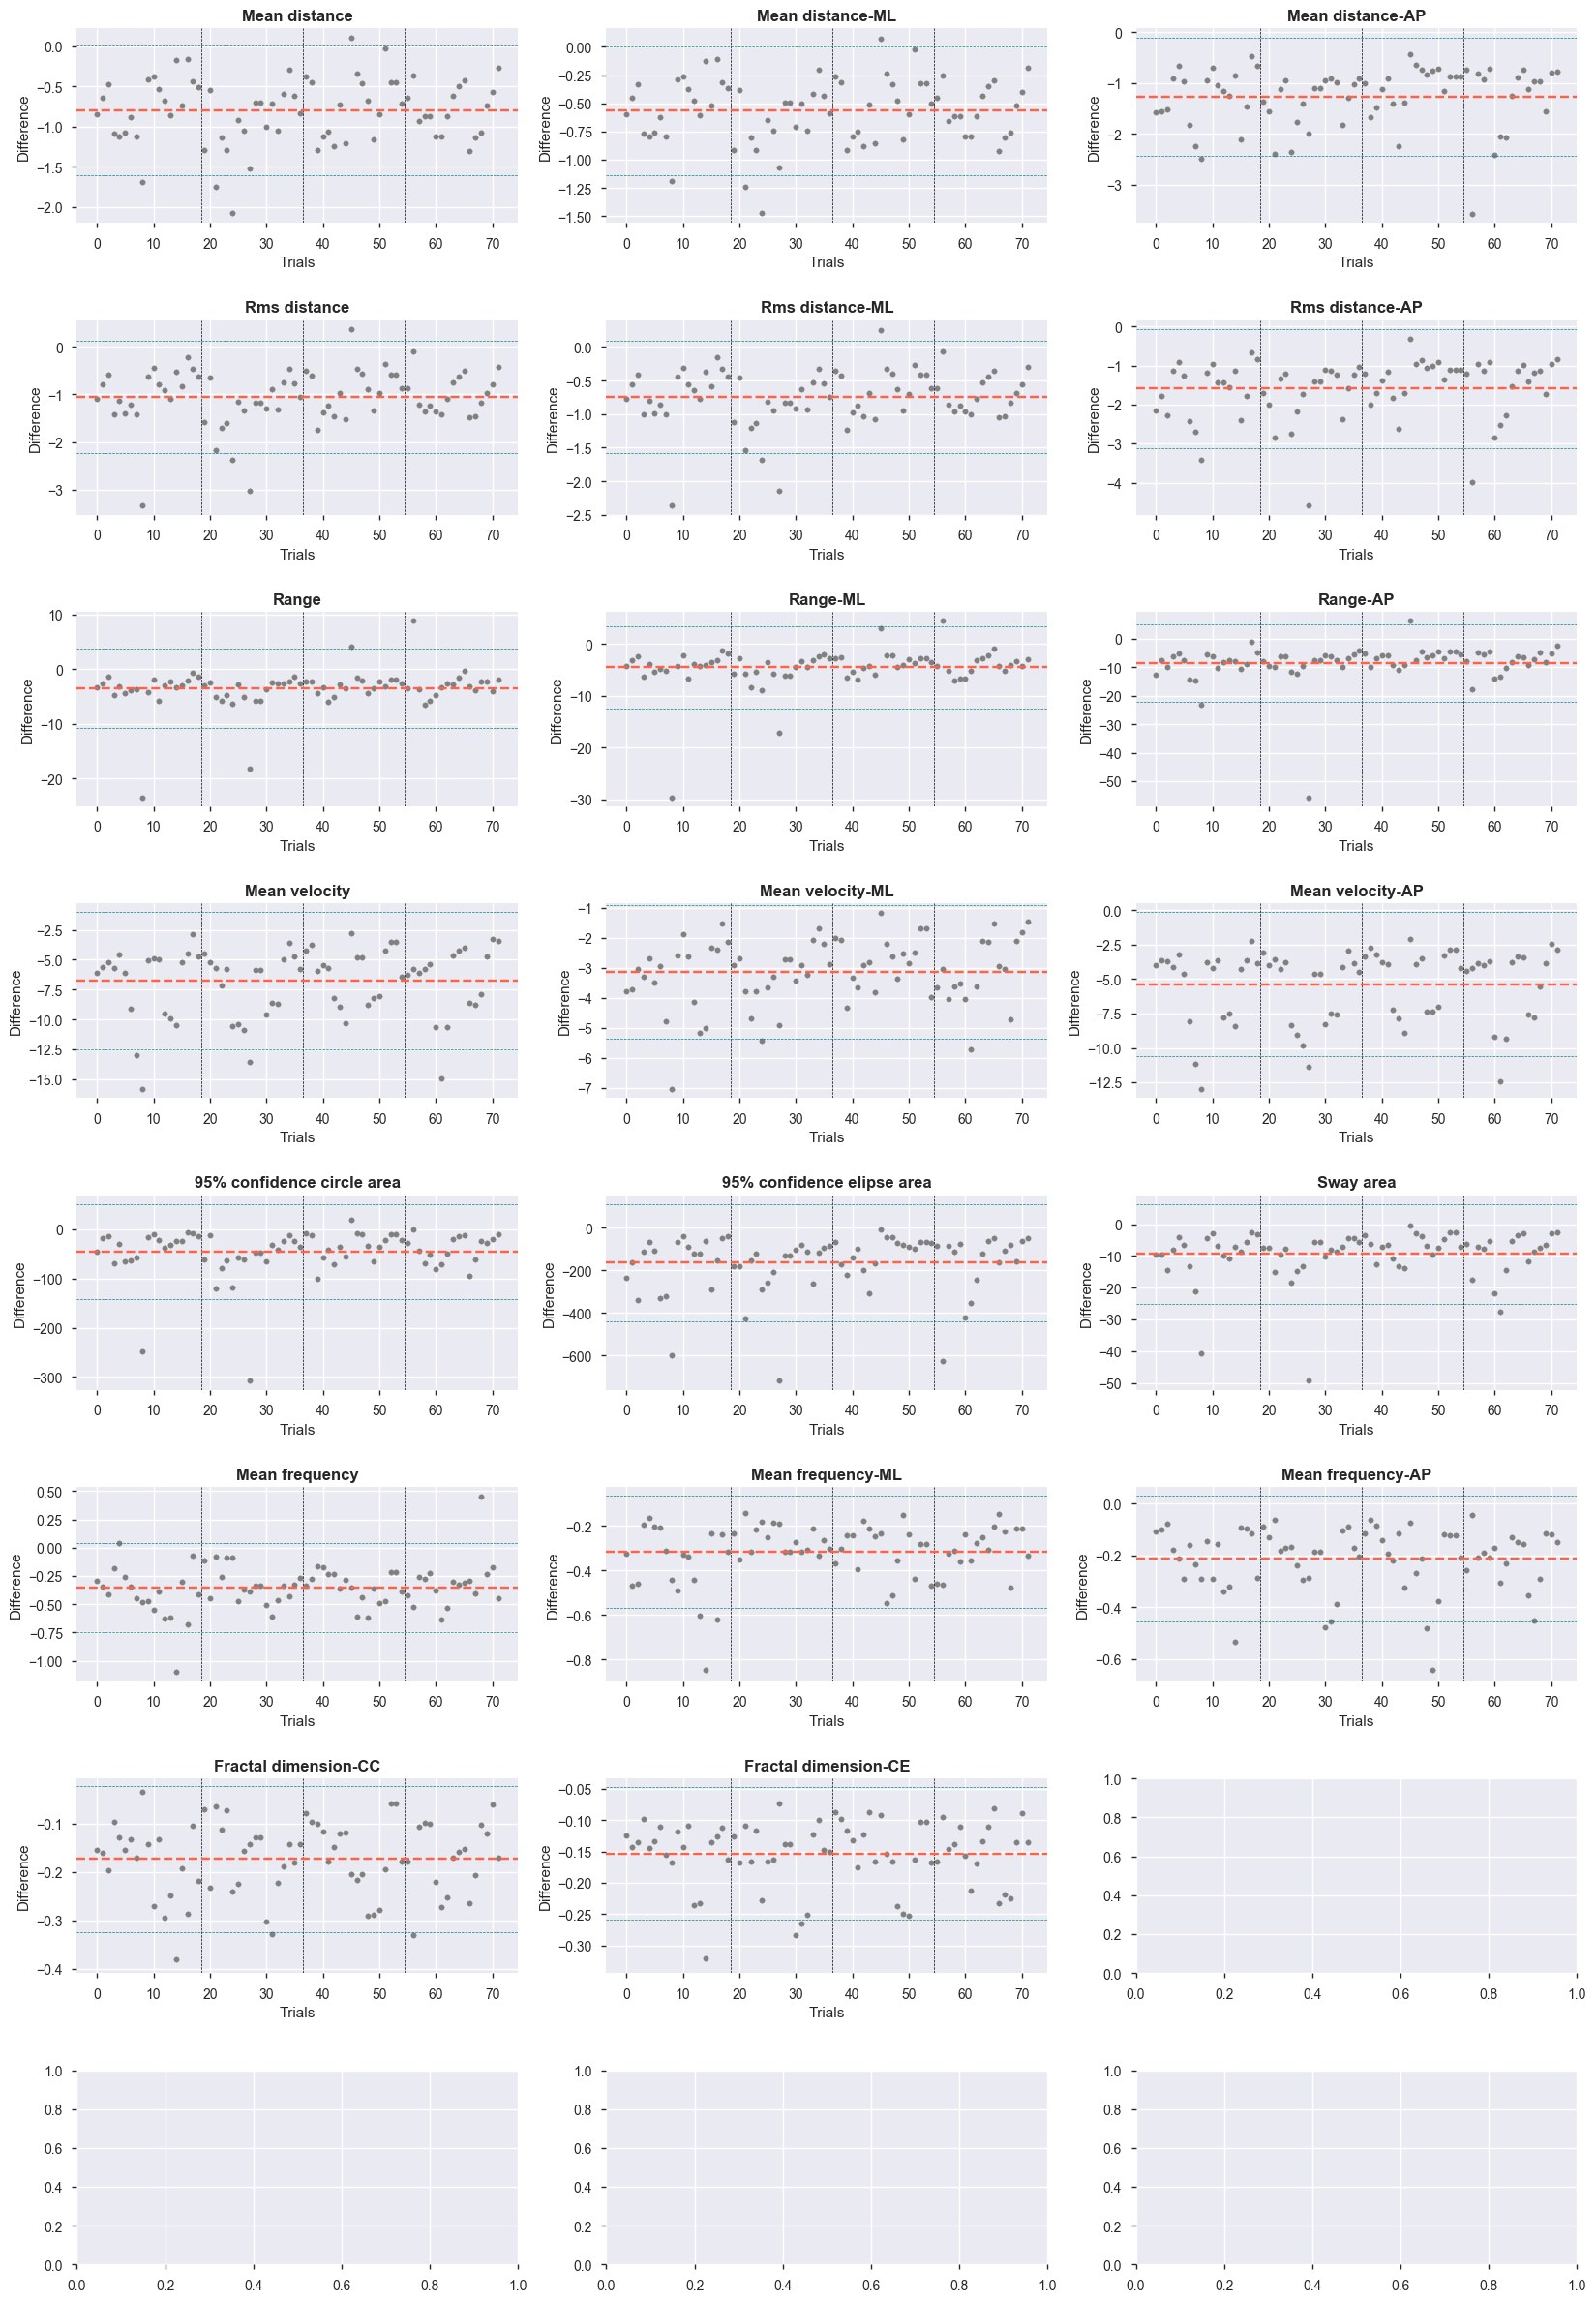

In [67]:
bland_altman_plot(wbb_time,fp_time)

###  Intraclass correlation coefficient (ICC) 



In [68]:
from rpy2.robjects import DataFrame, FloatVector, pandas2ri
from rpy2.robjects.packages import importr

In [69]:
rpy2.__version__

'2.9.5'

In [70]:
def compute_ICC(df1):
    """
    Compute the two-way mixed ICC.

    References
    ----------
    .. [1] R library used for the ICC implementation: http://www.personality-project.org/r/html/ICC.html

    Notes
    -----
    More info on what is the two-way mixed ICC: https://www.uvm.edu/~dhowell/methods8/Supplements/icc/More%20on%20ICCs.pdf
    """

    psych = importr("psych")
    wbb_numbers = ["1", "2", "3", "4"]
    dfs_1 = [df1.loc[(df1.index.get_level_values(3) == number)] for number in wbb_numbers]
    result_dict = {}
    # Loop over each feature
    for column in df1.columns:
        r_df = DataFrame({"WBB 1 feature": FloatVector(dfs_1[0][column]),
                              "WBB 2 feature": FloatVector(dfs_1[1][column]),
                              "WBB 3 feature": FloatVector(dfs_1[2][column]),
                              "WBB 4 feature": FloatVector(dfs_1[3][column])})
        # Compute the two way mixed ICC
        icc_res = psych.ICC(r_df)
        iccs_r_df = icc_res[0]

        iccs_df = pandas2ri.ri2py(iccs_r_df)

        # Select the ICC that corresponds to the 2 way mixed model (see links above)
        icc = iccs_df.iloc[4]["ICC"]
        icc_lower_bound = iccs_df.iloc[5]["lower bound"]
        icc_upper_bound = iccs_df.iloc[5]["upper bound"]
        icc_result = "{}({}, {})".format(round(icc, 4), round(icc_lower_bound, 4), round(icc_upper_bound, 4))

        # Store the results
        result_dict[column] = {}
        result_dict[column]["ICC"] = icc_result

    return result_dict

In [71]:
ICC_results = compute_ICC(wbb_time)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: singular fit

  warnings.warn(x, RRuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [72]:
ICC_results_df = pd.DataFrame.from_dict(ICC_results).transpose()

In [73]:
ICC_results_df

,ICC
Mean distance,"0.6836(0.3513, 0.8683)"
Mean distance-ML,"0.6836(0.3513, 0.8683)"
Mean distance-AP,"0.7778(0.5463, 0.9079)"
Rms distance,"0.6764(0.3366, 0.8653)"
Rms distance-ML,"0.6764(0.3366, 0.8653)"
Rms distance-AP,"0.777(0.5459, 0.9078)"
Range,"0.2842(-0.4583, 0.7039)"
Range-ML,"0.437(-0.1466, 0.7672)"
Range-AP,"0.7119(0.4104, 0.8803)"
Mean velocity,"0.9156(0.827, 0.9649)"


In [74]:
def compute_ICC_2(df1):
    """
    Compute the two-way mixed ICC.

    References
    ----------
    .. [1] R library used for the ICC implementation: https://cran.r-project.org/web/packages/irr/irr.pdf

    Notes
    -----
    More info on what is the two-way mixed ICC: https://www.uvm.edu/~dhowell/methods8/Supplements/icc/More%20on%20ICCs.pdf
    """

    irr = importr("irr")

    wbb_numbers = ["1", "2", "3", "4"]
    dfs_1 = [df1.loc[(df1.index.get_level_values(3) == number)] for number in wbb_numbers]
    result_dict = {}
    # Loop over each feature
    for column in df1.columns:
        r_df = DataFrame({"WBB 1 feature": FloatVector(dfs_1[0][column]),
                              "WBB 2 feature": FloatVector(dfs_1[1][column]),
                              "WBB 3 feature": FloatVector(dfs_1[2][column]),
                              "WBB 4 feature": FloatVector(dfs_1[3][column])})
        # Compute the two way mixed ICC
        icc_res = irr.icc(r_df,"twoway","consistency","average")
        
        result_dict[column] = dict(zip(icc_res.names, list(icc_res)))
        
    return result_dict

In [75]:
ICC_results = compute_ICC_2(wbb_time)

In [76]:
ICC_results_df = pd.DataFrame.from_dict(ICC_results).transpose()

In [77]:
ICC_results_df

,Fvalue,conf.level,df1,df2,icc.name,lbound,model,p.value,r0,raters,subjects,type,ubound,unit,value
Mean distance,[3.1201414972456054],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.34295636736072044],[twoway],[0.0008603785885943085],[0.0],[4],[18],[consistency],[0.8665876909224829],[average],[0.6795017146232698]
Mean distance-ML,[3.1201414972456054],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.34295636736072044],[twoway],[0.0008603785885943085],[0.0],[4],[18],[consistency],[0.8665876909224829],[average],[0.6795017146232698]
Mean distance-AP,[4.518800999962576],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.546324544117833],[twoway],[1.4084060073403186e-05],[0.0],[4],[18],[consistency],[0.9078814752409843],[average],[0.7787023593187038]
Rms distance,[3.0589058530227704],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.32980313804919426],[twoway],[0.0010401089629735372],[0.0],[4],[18],[consistency],[0.8639169357289078],[average],[0.6730857214805048]
Rms distance-ML,[3.0589058530227717],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.3298031380491946],[twoway],[0.0010401089629735335],[0.0],[4],[18],[consistency],[0.8639169357289078],[average],[0.6730857214805049]
Rms distance-AP,[4.515035133180911],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.5459461458820347],[twoway],[1.423211034558998e-05],[0.0],[4],[18],[consistency],[0.9078046417098747],[average],[0.7785177810354081]
Range,[1.4057596193096626],[0.95],[17.0],[51.0],"[ICC(C,4)]",[-0.4583354618662021],[twoway],[0.17305054667506922],[0.0],[4],[18],[consistency],[0.7038858734606872],[average],[0.28864082716284184]
Range-ML,[1.7877033133560984],[0.95],[17.0],[51.0],"[ICC(C,4)]",[-0.1467613716339593],[twoway],[0.05642244355884079],[0.0],[4],[18],[consistency],[0.7671508025486327],[average],[0.44062306506403687]
Range-AP,[3.4765871465193485],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.410321382062498],[twoway],[0.00028932463271280623],[0.0],[4],[18],[consistency],[0.8802661160923667],[average],[0.7123615897271066]
Mean velocity,[11.399579877133798],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.8201627493473678],[twoway],[6.256441731372341e-12],[0.0],[4],[18],[consistency],[0.9634841558827009],[average],[0.9122774689262118]
